<a href="https://colab.research.google.com/github/Anisha-Tasneem/Phishing-Email-Detection/blob/main/XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocess & Model Train

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import psutil
import time

# Define a function to get current CPU and RAM usage
def get_resource_usage():
    cpu_usage = psutil.cpu_percent(interval=1)
    ram_usage = psutil.virtual_memory().used / (1024 ** 3)  # Convert bytes to GB
    return cpu_usage, ram_usage

# Measure resource usage before loading data
cpu_before, ram_before = get_resource_usage()

# Start timing data loading
start_time_data_loading = time.time()

# Load the dataset
file_path = '/content/drive/MyDrive/CSE445/Phishing_Email.csv'
data = pd.read_csv(file_path)

# End timing data loading
end_time_data_loading = time.time()

# Measure resource usage after loading data
cpu_after_loading, ram_after_loading = get_resource_usage()

# Check for missing values and handle them (if any)
data.dropna(inplace=True)

# Extract features and target variable
X = data['Email Text']
y = data['Email Type']

# Start timing preprocessing
start_time_preprocessing = time.time()

# Convert the email text to numerical features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Encode the target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

# End timing preprocessing
end_time_preprocessing = time.time()

# Measure resource usage before training
cpu_before_training, ram_before_training = get_resource_usage()

# Start timing training
start_time_training = time.time()

# Convert the data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define the parameters for XGBoost
params = {
    'objective': 'multi:softprob',
    'num_class': len(label_encoder.classes_),
    'max_depth': 6,
    'eta': 0.3,
    'eval_metric': 'mlogloss'
}

# Train the model
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

# End timing training
end_time_training = time.time()

# Measure resource usage after training
cpu_after_training, ram_after_training = get_resource_usage()

# Start timing evaluation
start_time_evaluation = time.time()

# Evaluate the model
preds = bst.predict(dtest)
pred_labels = preds.argmax(axis=1)

# Calculate accuracy
accuracy = (pred_labels == y_test).mean()

# End timing evaluation
end_time_evaluation = time.time()

# Print resource usage and other metrics
print(f'CPU usage before training: {cpu_before_training}%')
print(f'RAM usage before training: {ram_before_training:.2f} GB')
print(f'CPU usage after training: {cpu_after_training}%')
print(f'RAM usage after training: {ram_after_training:.2f} GB')
print(f'Total data loading time: {end_time_data_loading - start_time_data_loading:.2f} seconds')
print(f'Total preprocessing time: {end_time_preprocessing - start_time_preprocessing:.2f} seconds')
print(f'Total training time: {end_time_training - start_time_training:.2f} seconds')
print(f'Total evaluation time: {end_time_evaluation - start_time_evaluation:.2f} seconds')
print(f'Overall runtime: {end_time_evaluation - start_time_data_loading:.2f} seconds')
print(f'Accuracy: {accuracy * 100:.2f}%')

CPU usage before training: 57.8%
RAM usage before training: 1.39 GB
CPU usage after training: 2.5%
RAM usage after training: 1.36 GB
Total data loading time: 3.04 seconds
Total preprocessing time: 6.58 seconds
Total training time: 111.12 seconds
Total evaluation time: 0.03 seconds
Overall runtime: 123.79 seconds
Accuracy: 96.38%


# Hyper-parameter space exploration

In [3]:
import psutil
import time
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Measure resource usage before hyperparameter tuning
cpu_before_tuning, ram_before_tuning = get_resource_usage()

# Start timing hyperparameter tuning
start_time_tuning = time.time()

# Define the XGBoost classifier
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'max_depth': [3, 6, 9],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Choose RandomizedSearchCV
search = RandomizedSearchCV(xgb_clf, param_distributions=param_grid, n_iter=20, scoring='accuracy', n_jobs=-1, cv=3, random_state=42)

start_time_random = time.time()
# Perform hyperparameter tuning
search.fit(X_train, y_train)
end_time_random = time.time()

# End timing hyperparameter tuning
end_time_tuning = time.time()

# Measure resource usage after hyperparameter tuning
cpu_after_tuning, ram_after_tuning = get_resource_usage()

# Get the best parameters and best score
best_params = search.best_params_
best_cv_accuracy = search.best_score_

# Evaluate the best model on the test set
best_model = search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)

# Print resource usage and other metrics
print(f'Best Hyperparameters: {best_params}')
print(f'Best Cross-Validation Accuracy: {best_cv_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Best Hyperparameters: {'subsample': 0.9, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best Cross-Validation Accuracy: 96.19%
Test Accuracy: 96.22%


# Learning curve

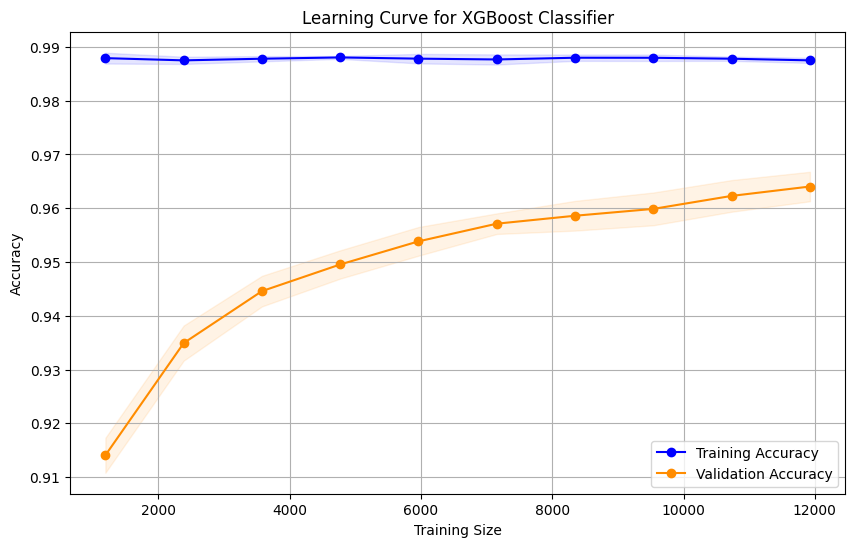

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier

# Define the XGBoost classifier with the best parameters
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)

# Define the range of training set sizes to use for generating the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve
train_sizes, train_scores, validation_scores = learning_curve(
    estimator=xgb_clf,
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Calculate the mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Accuracy')
plt.plot(train_sizes, validation_scores_mean, 'o-', color='darkorange', label='Validation Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color='darkorange')

# Customize the plot
plt.title('Learning Curve for XGBoost')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)

# Display the plot
plt.show()

# Effects of the regularizers

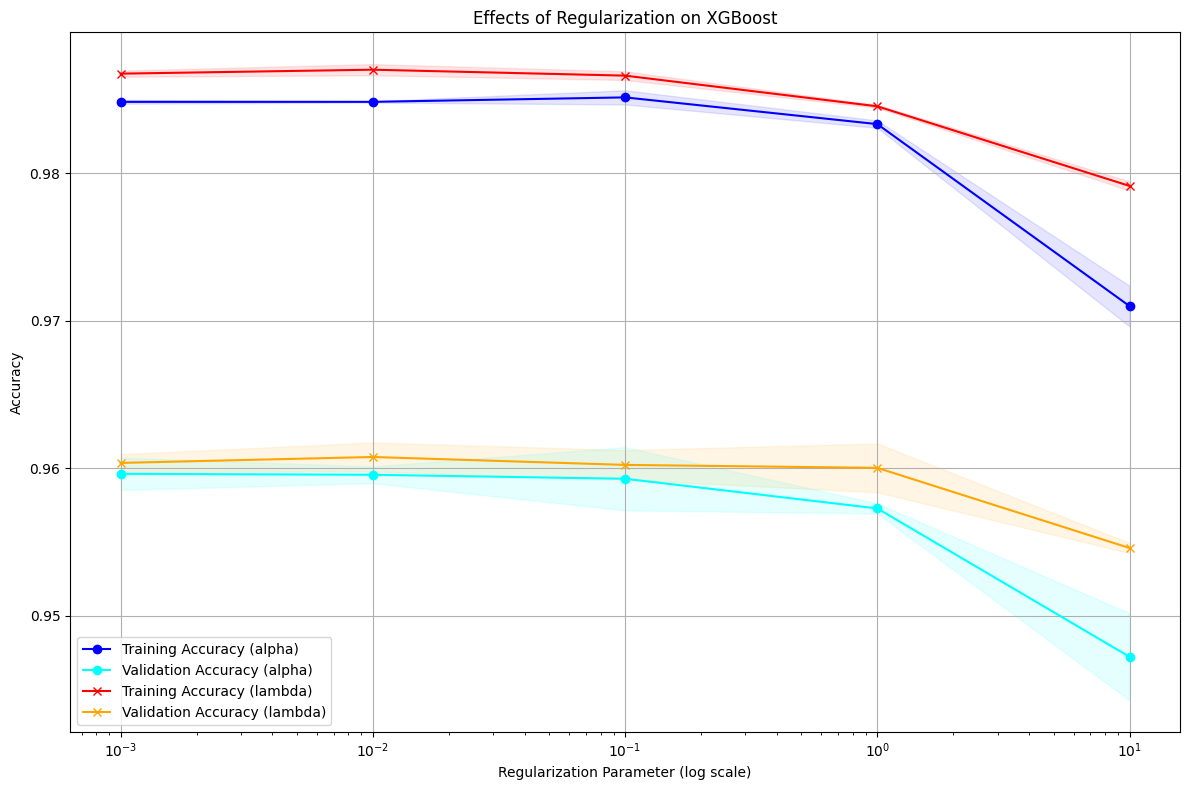

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from xgboost import XGBClassifier

# Define the range of values for the regularization parameters
alpha_range = np.logspace(-3, 1, 5)   # Example range for alpha
lambda_range = np.logspace(-3, 1, 5)  # Example range for lambda

# Define the XGBoost classifier
xgb_clf_alpha = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', reg_lambda=1, random_state=42)
xgb_clf_lambda = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', alpha=0, random_state=42)

# Compute validation curve values for alpha
train_scores_alpha, test_scores_alpha = validation_curve(
    xgb_clf_alpha, X_train, y_train, param_name="alpha", param_range=alpha_range, cv=3, scoring="accuracy", n_jobs=-1
)

# Compute validation curve values for lambda
train_scores_lambda, test_scores_lambda = validation_curve(
    xgb_clf_lambda, X_train, y_train, param_name="reg_lambda", param_range=lambda_range, cv=3, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation of training and test scores for alpha
train_scores_alpha_mean = np.mean(train_scores_alpha, axis=1)
train_scores_alpha_std = np.std(train_scores_alpha, axis=1)
test_scores_alpha_mean = np.mean(test_scores_alpha, axis=1)
test_scores_alpha_std = np.std(test_scores_alpha, axis=1)

# Calculate mean and standard deviation of training and test scores for lambda
train_scores_lambda_mean = np.mean(train_scores_lambda, axis=1)
train_scores_lambda_std = np.std(train_scores_lambda, axis=1)
test_scores_lambda_mean = np.mean(test_scores_lambda, axis=1)
test_scores_lambda_std = np.std(test_scores_lambda, axis=1)

# Plot validation curve for alpha and lambda on the same graph
plt.figure(figsize=(12, 8))

# Plot for alpha
plt.semilogx(alpha_range, train_scores_alpha_mean, label='Training Accuracy (alpha)', marker='o', color='blue')
plt.semilogx(alpha_range, test_scores_alpha_mean, label='Validation Accuracy (alpha)', marker='o', color='cyan')
plt.fill_between(alpha_range, train_scores_alpha_mean - train_scores_alpha_std,
                 train_scores_alpha_mean + train_scores_alpha_std, alpha=0.1, color='blue')
plt.fill_between(alpha_range, test_scores_alpha_mean - test_scores_alpha_std,
                 test_scores_alpha_mean + test_scores_alpha_std, alpha=0.1, color='cyan')

# Plot for lambda
plt.semilogx(lambda_range, train_scores_lambda_mean, label='Training Accuracy (lambda)', marker='x', color='red')
plt.semilogx(lambda_range, test_scores_lambda_mean, label='Validation Accuracy (lambda)', marker='x', color='orange')
plt.fill_between(lambda_range, train_scores_lambda_mean - train_scores_lambda_std,
                 train_scores_lambda_mean + train_scores_lambda_std, alpha=0.1, color='red')
plt.fill_between(lambda_range, test_scores_lambda_mean - test_scores_lambda_std,
                 test_scores_lambda_mean + test_scores_lambda_std, alpha=0.1, color='orange')

plt.title('Effects of Regularization on XGBoost')
plt.xlabel('Regularization Parameter (log scale)')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

plt.show()

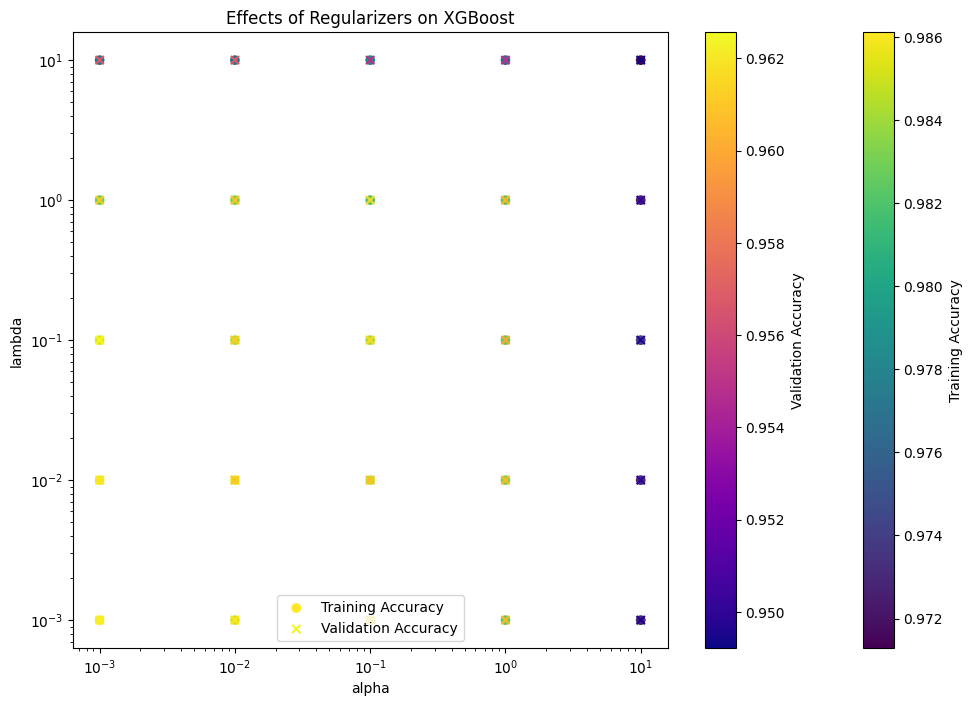

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# Assuming X_train, X_test, y_train, y_test are already defined

# Define ranges for the regularization parameters
alpha_values = np.logspace(-3, 1, 5)
lambda_values = np.logspace(-3, 1, 5)

# Initialize lists to store results
train_scores = []
validation_scores = []

# Iterate over the ranges of alpha and lambda
for alpha in alpha_values:
    for lambda_ in lambda_values:
        # Define the XGBoost classifier with current alpha and lambda
        xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', alpha=alpha, reg_lambda=lambda_)

        # Train the model and compute the cross-validation scores
        xgb_clf.fit(X_train, y_train)
        train_score = xgb_clf.score(X_train, y_train)
        validation_score = np.mean(cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='accuracy'))

        # Append the scores to the lists
        train_scores.append((alpha, lambda_, train_score))
        validation_scores.append((alpha, lambda_, validation_score))

# Convert results to numpy arrays for easy plotting
train_scores = np.array(train_scores)
validation_scores = np.array(validation_scores)

# Plot the effects of alpha and lambda on the training and validation scores
fig, ax = plt.subplots(figsize=(12, 8))

# Training scores plot
scatter1 = ax.scatter(train_scores[:, 0], train_scores[:, 1], c=train_scores[:, 2], cmap='viridis', marker='o', label='Training Accuracy')
# Validation scores plot
scatter2 = ax.scatter(validation_scores[:, 0], validation_scores[:, 1], c=validation_scores[:, 2], cmap='plasma', marker='x', label='Validation Accuracy')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('lambda')
ax.set_title('Effects of Regularizers on XGBoost')
ax.legend(loc='best')

# Add colorbars
cbar1 = plt.colorbar(scatter1, ax=ax, label='Training Accuracy')
cbar2 = plt.colorbar(scatter2, ax=ax, label='Validation Accuracy')

plt.show()

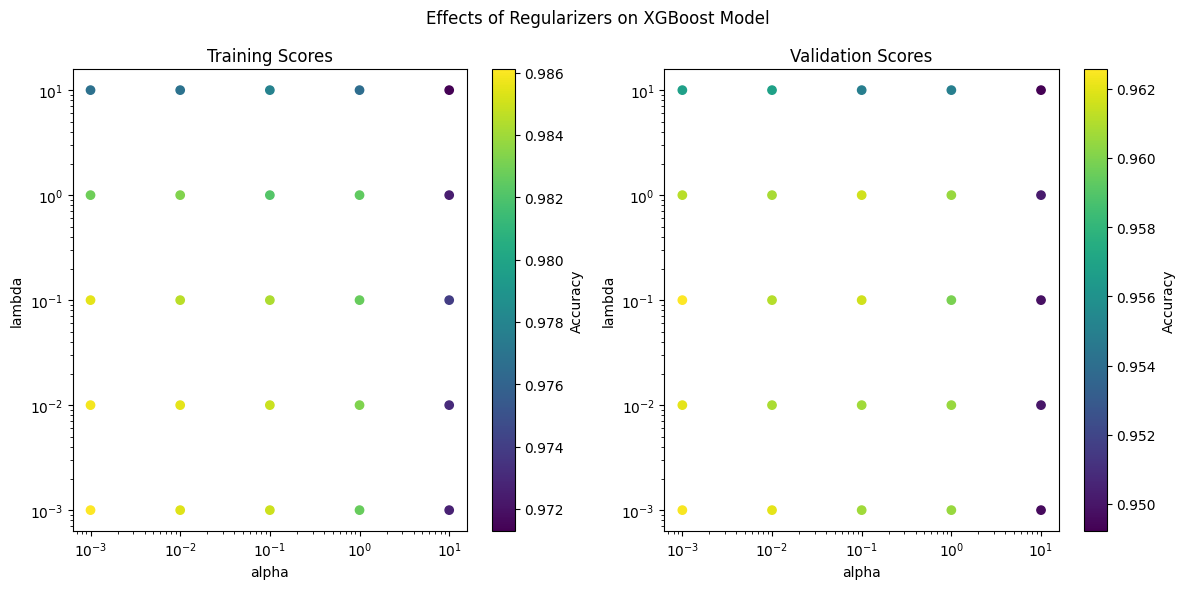

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score

# Assuming X_train, X_test, y_train, y_test are already defined

# Define ranges for the regularization parameters
alpha_values = np.logspace(-3, 1, 5)
lambda_values = np.logspace(-3, 1, 5)

# Initialize lists to store results
train_scores = []
validation_scores = []

# Iterate over the ranges of alpha and lambda
for alpha in alpha_values:
    for lambda_ in lambda_values:
        # Define the XGBoost classifier with current alpha and lambda
        xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', alpha=alpha, reg_lambda=lambda_)

        # Train the model and compute the cross-validation scores
        xgb_clf.fit(X_train, y_train)
        train_score = xgb_clf.score(X_train, y_train)
        validation_score = np.mean(cross_val_score(xgb_clf, X_train, y_train, cv=5, scoring='accuracy'))

        # Append the scores to the lists
        train_scores.append((alpha, lambda_, train_score))
        validation_scores.append((alpha, lambda_, validation_score))

# Convert results to numpy arrays for easy plotting
train_scores = np.array(train_scores)
validation_scores = np.array(validation_scores)

# Plot the effects of alpha and lambda on the training and validation scores
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Training scores plot
scatter1 = ax[0].scatter(train_scores[:, 0], train_scores[:, 1], c=train_scores[:, 2], cmap='viridis', marker='o')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('lambda')
ax[0].set_title('Training Scores')
fig.colorbar(scatter1, ax=ax[0], label='Accuracy')

# Validation scores plot
scatter2 = ax[1].scatter(validation_scores[:, 0], validation_scores[:, 1], c=validation_scores[:, 2], cmap='viridis', marker='o')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('alpha')
ax[1].set_ylabel('lambda')
ax[1].set_title('Validation Scores')
fig.colorbar(scatter2, ax=ax[1], label='Accuracy')

plt.suptitle('Effects of Regularizers on XGBoost Model')
plt.show()

In [8]:
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Initialize the XGBoost classifier with best parameters
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)

# Train the model
xgb_clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = xgb_clf.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      1518
           1       0.98      0.95      0.97      2209

    accuracy                           0.96      3727
   macro avg       0.96      0.96      0.96      3727
weighted avg       0.96      0.96      0.96      3727



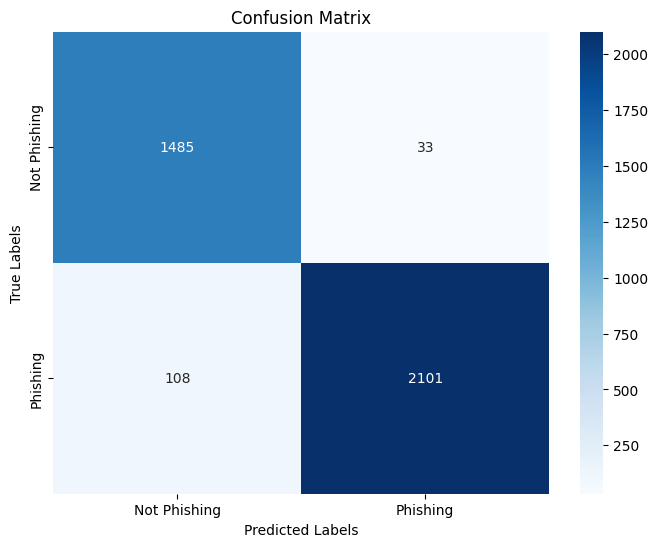

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier

# Initialize the XGBoost classifier with best parameters
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)

# Train the model
xgb_clf.fit(X_train, y_train)

# Predict the labels for the test set
y_pred = xgb_clf.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Phishing', 'Phishing'], yticklabels=['Not Phishing', 'Phishing'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
import psutil

# Get CPU usage
cpu_usage = psutil.cpu_percent()
print(f'CPU Usage: {cpu_usage}%')

# Get memory usage
memory_info = psutil.virtual_memory()
print(f'Total Memory: {memory_info.total} bytes')
print(f'Used Memory: {memory_info.used} bytes')
print(f'Free Memory: {memory_info.available} bytes')

# Get GPU information (if available)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

CPU Usage: 85.7%
Total Memory: 13609435136 bytes
Used Memory: 1934950400 bytes
Free Memory: 11339309056 bytes


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13123998251861659524
 xla_global_id: -1]